In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
import os

import pysindy as ps

# Seed the random number generators for reproducibility
np.random.seed(100)

# Function with non unqiue PDE: $u(t,x)=sin(x+t)$
The function $u$ solves the equations $u_t = u_x$ and $u_t= u_x+\lambda (u^2+u_x^2-1)$. Two things we can do here: show that the Jacobi criterion for analytic PDEs does not help and then apply the methods for polynomials to show non-uniqueness.

In [22]:
x_0, x_end = 0, 5
t_0, t_end = 0, 5
nx, nt = (300, 200)
x = np.linspace(x_0, x_end, nx)
t = np.linspace(t_0, t_end, nt)
tv, xv = np.meshgrid(t, x)

u = np.sin(xv + tv)

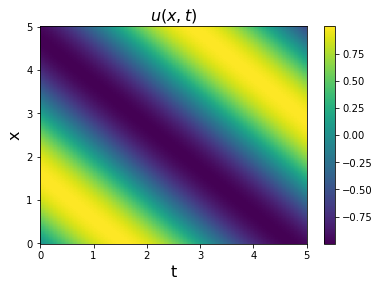

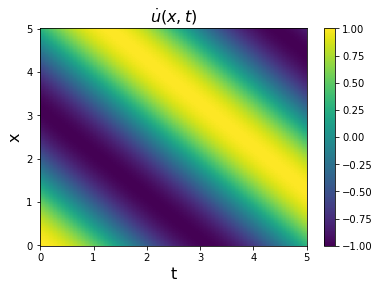

In [23]:
# Plot u and u_dot
plt.figure()
plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
plt.colorbar()
plt.figure()

dt = t[1] - t[0]
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$\dot{u}(x, t)$', fontsize=16)

plt.colorbar()
plt.show()

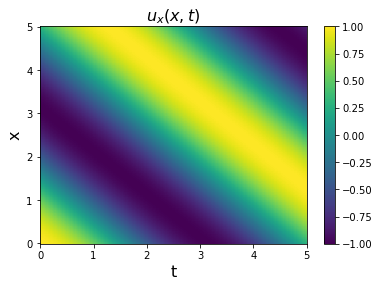

In [24]:
dx = x[1] - x[0]
ux = ps.FiniteDifference(d=1, axis=0, drop_endpoints=False)._differentiate(u, dx)


# Plot derivative results
plt.pcolormesh(t, x, ux)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u_x(x, t)$', fontsize=16)
plt.colorbar()
plt.show()

In [25]:
u = u.reshape(len(x), len(t), 1)

# Define PDE library that is quadratic in u, and
# third-order in spatial derivatives of u.
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=1, spatial_grid=x,
                        include_bias=True, is_uniform=True)

# Fit the model with different optimizers.
# Using normalize_columns = True to improve performance.
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=5, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SR3 model, L0 norm: ')
optimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2,
                   thresholder='l0', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SR3 model, L1 norm: ')
optimizer = ps.SR3(threshold=0.05, max_iter=10000, tol=1e-15,
                   thresholder='l1', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SSR model: ')
optimizer = ps.SSR(normalize_columns=True, kappa=5e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SSR (metric = model residual) model: ')
optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, kappa=5e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('FROLs model: ')
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-5)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

STLSQ model: 
(x0)' = 1.000 x0_1
SR3 model, L0 norm: 
(x0)' = 1.000 x0_1
SR3 model, L1 norm: 
(x0)' = 1.000 x0_1
SSR model: 
(x0)' = 1.000 x0_1
SSR (metric = model residual) model: 
(x0)' = 1.000 x0_1
FROLs model: 
(x0)' = 1.000 x0_1


So, we see that all models find the desired equation.
## Check now numerically if this is the unique equation

We already know that the equation is not unique. First we want to show that the Jacobi criterion for analytic PDEs does not help, as it can only be used to show uniqueness and as $u$ is not algebraic we cannot use the other direction.
### Jacobi criterion

In [26]:
from numpy.linalg import matrix_rank, svd

In [27]:
fd_order = 3
ut = ps.FiniteDifference(order=fd_order, d=1, axis=1, drop_endpoints=False)._differentiate(u, t=dt)
utx = ps.FiniteDifference(order=fd_order, d=1, axis=0, drop_endpoints=False)._differentiate(ut, dx)
ux = ps.FiniteDifference(order=fd_order, d=1, axis=0, drop_endpoints=False)._differentiate(u, dx)
uxx = ps.FiniteDifference(order=fd_order, d=2, axis=0, drop_endpoints=False)._differentiate(u, dx) 
ut.shape

(300, 200, 1)

In [28]:
x_i, t_j = 10, 10
ut[x_i,t_j], ux[x_i,t_j], utx[x_i,t_j], uxx[x_i,t_j]

(array([0.91370698]),
 array([0.91370737]),
 array([-0.40637398]),
 array([-0.40636295]))

In [29]:
jacobian = np.array([[ut[x_i,t_j], ux[x_i,t_j]], [utx[x_i,t_j], uxx[x_i,t_j]]]).reshape(2,2)
jacobian, svd(jacobian, compute_uv=False)

(array([[ 0.91370698,  0.91370737],
        [-0.40637398, -0.40636295]]),
 array([1.41421083e+00, 7.23601018e-06]))

In [30]:
space_range = 28
time_range = 18
svs = np.zeros([space_range, time_range])
for i in range(space_range):
    for j in range(time_range):
        x_i, t_j = i * 10 + 10, j * 10 + 10
        jacobian = np.array([[ut[x_i,t_j], ux[x_i,t_j]], [utx[x_i,t_j], uxx[x_i,t_j]]]).reshape(2,2)
        sv = svd(jacobian, compute_uv=False)[-1]
        svs[i,j] = sv
np.min(svs)

2.2591545022432136e-07

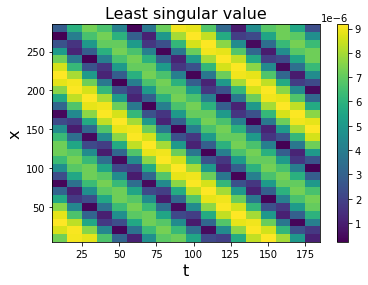

In [31]:
t_grid, x_grid = np.arange(time_range) * 10 + 10, np.arange(space_range) * 10 + 10
# Plot derivative results
plt.pcolormesh(t_grid, x_grid, svs)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'Least singular value', fontsize=16)
plt.colorbar()
plt.show()

In [32]:
fd_orders = [2, 7]
sv_ratios = np.zeros([space_range, time_range])
svs = np.zeros([2, space_range, time_range])
for k, fd_order in enumerate(fd_orders):
    ut = ps.FiniteDifference(order=fd_order, d=1, axis=1, drop_endpoints=False)._differentiate(u, t=dt)
    utx = ps.FiniteDifference(order=fd_order, d=1, axis=0, drop_endpoints=False)._differentiate(ut, dx)
    ux = ps.FiniteDifference(order=fd_order, d=1, axis=0, drop_endpoints=False)._differentiate(u, dx)
    uxx = ps.FiniteDifference(order=fd_order, d=2, axis=0, drop_endpoints=False)._differentiate(u, dx) 
    space_range = 28
    time_range = 18
    for i in range(space_range):
        for j in range(time_range):
            x_i, t_j = i * 10 + 10, j * 10 + 10
            jacobian = np.array([[ut[x_i,t_j], ux[x_i,t_j]], [utx[x_i,t_j], uxx[x_i,t_j]]]).reshape(2,2)
            sv = svd(jacobian, compute_uv=False)[-1]
            svs[k,i,j] = sv

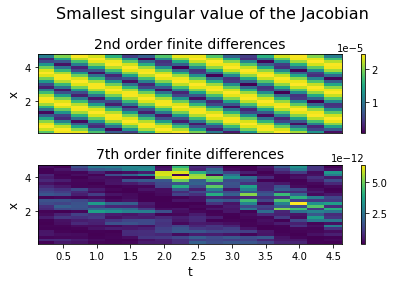

In [33]:
t_grid, x_grid = (np.arange(time_range) * 10 + 10) / 200 * (t_end - t_0) + t_0, (np.arange(space_range) * 10 + 10) / 300 * (x_end - x_0) + x_0
# Plot derivative results
fig, axes = plt.subplots(2,1)
fig.suptitle(r'Smallest singular value of the Jacobian', fontsize=16)
# axes[0].plot(np.arange(10), np.arange(10))
c = axes[0].pcolor(t_grid, x_grid, svs[0])
axes[0].set_title('2nd order finite differences', fontsize=14)
axes[0].set_ylabel('x', fontsize=12)
axes[0].set_xticks([])
fig.colorbar(c, ax=axes[0])
c = axes[1].pcolor(t_grid, x_grid, svs[1])
axes[1].set_title('7th order finite differences', fontsize=14)
axes[1].set_xlabel('t', fontsize=12)
axes[1].set_ylabel('x', fontsize=12)
fig.colorbar(c, ax=axes[1])
plt.tight_layout()
plt.show()

## Polynomial criterion
Let us validate now our believe that it is actually not the unique PDE by checking the condition of the feature matrix consisting out of $u$, $u_x$ and their derivatives.

In [34]:
from itertools import product

In [35]:
def monomials(features, order):
    multi_indices = []
    indices = np.arange(order + 1)
    number_features = features.shape[0]
    repeat_indices = [indices for i in range(number_features)]
    for i in product(*repeat_indices):
        if sum(i) <= order:
            multi_indices += [i]
    new_features = []
    for multi_index in multi_indices:
        new_feature = 1
        for i, j in enumerate(multi_index):
            new_feature *= features[i]**j
        new_features.append(new_feature.reshape(1,-1))
    return np.concatenate(new_features,axis=0)

In [36]:
fd_order = 3
ux = ps.FiniteDifference(order=fd_order, d=1, axis=0, drop_endpoints=False)._differentiate(u, dx)
u_flat, u_x_flat = u.flatten(), ux.flatten()

In [37]:
base_features = np.concatenate([u_flat.reshape(len(u_flat),-1), u_x_flat.reshape(len(u_flat),-1)], axis=1).T 
base_features.shape

(2, 60000)

In [38]:
library = monomials(base_features, order=2)
library.shape

(6, 60000)

In [39]:
matrix_rank(library), svd(library, compute_uv=False)

(6,
 array([3.00535619e+02, 1.75778573e+02, 1.70133631e+02, 1.22006226e+02,
        8.63679969e+01, 1.09051778e-05]))

Looks like we have actually algebraic dependence here but let us check the 
### Singular value ratio plot

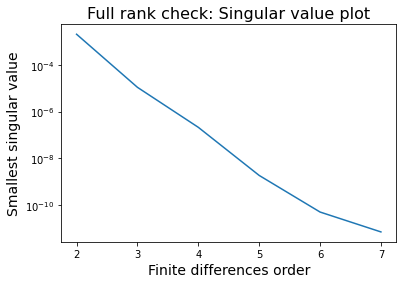

In [40]:
polynomial_order = 2
distance_svs = []
fd_orders = range(2, 8)
for fd_order in fd_orders:
    ux = ps.FiniteDifference(order=fd_order, d=1, axis=0,
                         drop_endpoints=False)._differentiate(u, dx)

    u_flat, u_x_flat = u.flatten(), ux.flatten()
    base_features = np.concatenate([u_flat.reshape(len(u_flat),-1), u_x_flat.reshape(len(u_flat),-1)], axis=1).T 
    library = monomials(base_features, order=polynomial_order)
    svs = svd(library, compute_uv=False)
    distance_svs.append(svs[-1])
plt.plot(range(2,8), distance_svs)
plt.title('Full rank check: Singular value plot', size=16)
plt.xlabel('Finite differences order', size=14)
plt.ylabel('Smallest singular value', size=14)
plt.yscale('log')

So, we can conclude that it is actually not the unique PDE (as we knew before already).